In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
from itertools import chain, combinations
from collections import defaultdict

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import implicit
from scipy import sparse

import warnings
warnings.filterwarnings("ignore")

# set seaborn aesthetic
sns.set_style("whitegrid")
sns.set_context("paper")

# set plot colors
PLOT_COLOR = "#3e9a4c"
PLOT_CMAP = "Greens"

%config InlineBackend.figure_format = "retina"

In [5]:
##Importin the train and test data sets
train_df = pd.read_csv("/Users/karanbhutani/Downloads/vanshaj/Groceries data train.csv")
test_df = pd.read_csv("/Users/karanbhutani/Downloads/vanshaj/Groceries data test.csv")

In [6]:
train_df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week
0,3021,30/01/2015,frankfurter,2015,1,30,4
1,1292,24/10/2015,pork,2015,10,24,5
2,4206,4/04/2014,root vegetables,2014,4,4,4
3,4369,25/08/2015,onions,2015,8,25,1
4,1522,1/07/2014,waffles,2014,7,1,1


In [7]:
train_df.tail()

,Member_number,Date,itemDescription,year,month,day,day_of_week
26995,4206,14/01/2014,rolls/buns,2014,1,14,1
26996,1660,15/06/2014,domestic eggs,2014,6,15,6
26997,1595,10/05/2015,liver loaf,2015,5,10,6
26998,3231,31/03/2015,sausage,2015,3,31,1
26999,2550,7/12/2014,canned beer,2014,12,7,6


In [8]:
train_df = train_df.sort_values("Date")

In [9]:
train_df

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,1/01/2014,shopping bags,2014,1,1,2
10966,1440,1/01/2014,yogurt,2014,1,1,2
276,1659,1/01/2014,frozen vegetables,2014,1,1,2
18723,3956,1/01/2014,chocolate,2014,1,1,2
21809,2237,1/01/2014,bottled water,2014,1,1,2
...,...,...,...,...,...,...,...
19189,1269,9/12/2015,other vegetables,2015,12,9,2
26391,1077,9/12/2015,soda,2015,12,9,2
1610,1269,9/12/2015,liquor,2015,12,9,2
25568,3653,9/12/2015,rolls/buns,2015,12,9,2


In [10]:
train_df["itemDescription"].value_counts()

whole milk               1709
other vegetables         1320
rolls/buns               1197
soda                     1060
yogurt                    928
                         ... 
rubbing alcohol             3
baby cosmetics              3
frozen chicken              2
kitchen utensil             1
preservation products       1
Name: itemDescription, Length: 167, dtype: int64

In [11]:
train_df["itemDescription"].unique()

array(['shopping bags', 'yogurt', 'frozen vegetables', 'chocolate',
       'bottled water', 'specialty chocolate', 'hamburger meat',
       'whole milk', 'berries', 'curd', 'citrus fruit', 'dishes',
       'coffee', 'sausage', 'candles', 'bottled beer',
       'whipped/sour cream', 'frozen potato products', 'onions',
       'tropical fruit', 'butter', 'domestic eggs', 'soda',
       'Instant food products', 'flower (seeds)', 'spread cheese',
       'pot plants', 'turkey', 'other vegetables', 'meat', 'white bread',
       'fruit/vegetable juice', 'beef', 'pork', 'margarine', 'ham',
       'frankfurter', 'pip fruit', 'frozen meals', 'brown bread',
       'pastry', 'salty snack', 'pickled vegetables', 'dessert', 'salt',
       'rolls/buns', 'newspapers', 'root vegetables', 'soap', 'UHT-milk',
       'roll products ', 'long life bakery product', 'hard cheese',
       'canned beer', 'waffles', 'grapes', 'sauces', 'chewing gum',
       'flower soil/fertilizer', 'white wine', 'cocoa drinks', 

In [12]:
train_df["year"].value_counts()

2015    14284
2014    12716
Name: year, dtype: int64

In [13]:
year14 = train_df[train_df.year == 2014]
year15 = train_df[train_df.year == 2015]

In [14]:
year14.head(5)

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,1/01/2014,shopping bags,2014,1,1,2
10966,1440,1/01/2014,yogurt,2014,1,1,2
276,1659,1/01/2014,frozen vegetables,2014,1,1,2
18723,3956,1/01/2014,chocolate,2014,1,1,2
21809,2237,1/01/2014,bottled water,2014,1,1,2


In [15]:
year15.head(5)

,Member_number,Date,itemDescription,year,month,day,day_of_week
7348,1235,1/01/2015,spread cheese,2015,1,1,3
7606,2768,1/01/2015,pot plants,2015,1,1,3
18121,4104,1/01/2015,soda,2015,1,1,3
12157,1422,1/01/2015,turkey,2015,1,1,3
26164,2641,1/01/2015,other vegetables,2015,1,1,3


In [16]:
year14.shape

(12716, 7)

In [17]:
year15.shape

(14284, 7)

In [18]:
year14.duplicated('Member_number')

9895     False
10966    False
276      False
18723    False
21809    False
         ...  
18630     True
22180     True
25075     True
8130      True
25757     True
Length: 12716, dtype: bool

In [19]:
train_df.duplicated('Member_number')

9895     False
10966    False
276      False
18723    False
21809    False
         ...  
19189     True
26391     True
1610      True
25568     True
10855     True
Length: 27000, dtype: bool

<AxesSubplot:ylabel='count'>

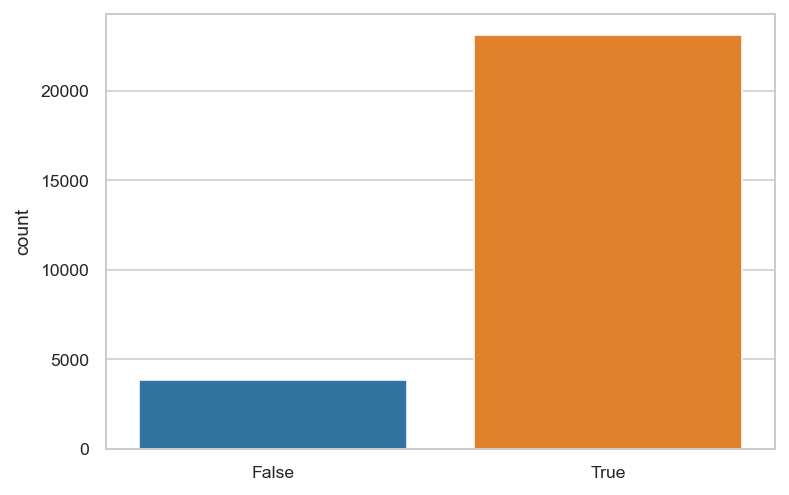

In [20]:
sns.countplot(x=train_df.duplicated('Member_number'))

We can see that customers buy different items, now we will proceed to see what all items are repeated purchases



In [21]:
train_df.head(4)

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,1/01/2014,shopping bags,2014,1,1,2
10966,1440,1/01/2014,yogurt,2014,1,1,2
276,1659,1/01/2014,frozen vegetables,2014,1,1,2
18723,3956,1/01/2014,chocolate,2014,1,1,2


<AxesSubplot:xlabel='itemDescription', ylabel='count'>

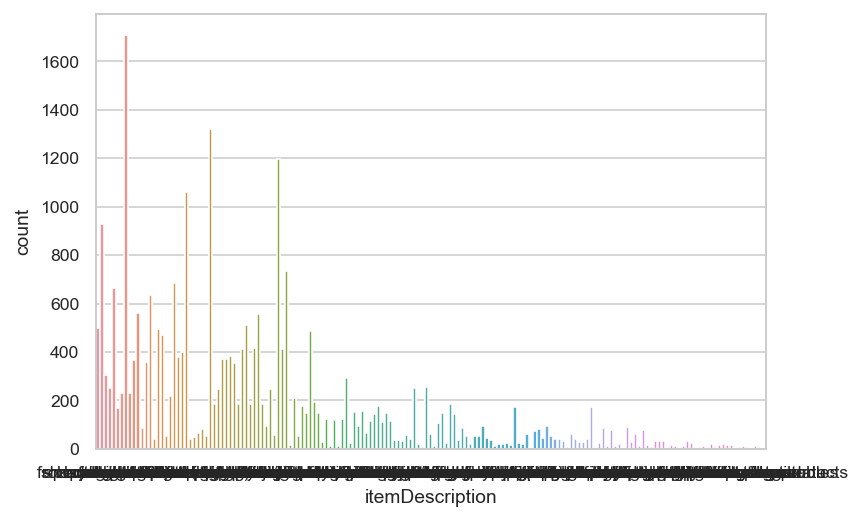

In [22]:
sns.countplot(x=train_df["itemDescription"])

In [23]:
purchased_items = train_df.iloc[:,[0,2]]

In [24]:
purchased_items.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27000 entries, 9895 to 10855
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    27000 non-null  int64 
 1   itemDescription  27000 non-null  object
dtypes: int64(1), object(1)
memory usage: 632.8+ KB


In [25]:
train_df.head(10)

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,1/01/2014,shopping bags,2014,1,1,2
10966,1440,1/01/2014,yogurt,2014,1,1,2
276,1659,1/01/2014,frozen vegetables,2014,1,1,2
18723,3956,1/01/2014,chocolate,2014,1,1,2
21809,2237,1/01/2014,bottled water,2014,1,1,2
21795,1659,1/01/2014,specialty chocolate,2014,1,1,2
20101,1789,1/01/2014,hamburger meat,2014,1,1,2
5106,3797,1/01/2014,whole milk,2014,1,1,2
15878,2974,1/01/2014,berries,2014,1,1,2
24705,1381,1/01/2014,curd,2014,1,1,2


In [26]:
train_df["itemDescription"] = train_df["itemDescription"].str.strip()
train_df["itemDescription"] = train_df["itemDescription"].str.lower()

test_df["itemDescription"] = test_df["itemDescription"].str.strip()
test_df["itemDescription"] = test_df["itemDescription"].str.lower()

In [27]:
train_df.head(10)

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,1/01/2014,shopping bags,2014,1,1,2
10966,1440,1/01/2014,yogurt,2014,1,1,2
276,1659,1/01/2014,frozen vegetables,2014,1,1,2
18723,3956,1/01/2014,chocolate,2014,1,1,2
21809,2237,1/01/2014,bottled water,2014,1,1,2
21795,1659,1/01/2014,specialty chocolate,2014,1,1,2
20101,1789,1/01/2014,hamburger meat,2014,1,1,2
5106,3797,1/01/2014,whole milk,2014,1,1,2
15878,2974,1/01/2014,berries,2014,1,1,2
24705,1381,1/01/2014,curd,2014,1,1,2


In [28]:
train_df["Date"] = pd.to_datetime(train_df["Date"])
test_df["Date"] = pd.to_datetime(test_df["Date"])

In [29]:
train_df.head(10)

,Member_number,Date,itemDescription,year,month,day,day_of_week
9895,2351,2014-01-01,shopping bags,2014,1,1,2
10966,1440,2014-01-01,yogurt,2014,1,1,2
276,1659,2014-01-01,frozen vegetables,2014,1,1,2
18723,3956,2014-01-01,chocolate,2014,1,1,2
21809,2237,2014-01-01,bottled water,2014,1,1,2
21795,1659,2014-01-01,specialty chocolate,2014,1,1,2
20101,1789,2014-01-01,hamburger meat,2014,1,1,2
5106,3797,2014-01-01,whole milk,2014,1,1,2
15878,2974,2014-01-01,berries,2014,1,1,2
24705,1381,2014-01-01,curd,2014,1,1,2


In [30]:
def generate_order_id(row):
    """Generate order ID as a concatenation of the member number and the purchase date."""
    member_number = str(row["Member_number"])
    date = row["Date"].strftime("%Y-%m-%d")
    return member_number + "_" + date


train_df["OrderId"] = train_df.apply(generate_order_id, axis=1)
test_df["OrderId"] = test_df.apply(generate_order_id, axis=1)

In [31]:
train_df["DoW_num"] = train_df["Date"].apply(lambda x: x.strftime("%w"))
train_df["DoW"] = train_df["Date"].apply(lambda x: x.strftime("%A"))

In [32]:
train_df.head(3)

,Member_number,Date,itemDescription,year,month,day,day_of_week,OrderId,DoW_num,DoW
9895,2351,2014-01-01,shopping bags,2014,1,1,2,2351_2014-01-01,3,Wednesday
10966,1440,2014-01-01,yogurt,2014,1,1,2,1440_2014-01-01,3,Wednesday
276,1659,2014-01-01,frozen vegetables,2014,1,1,2,1659_2014-01-01,3,Wednesday


<AxesSubplot:>

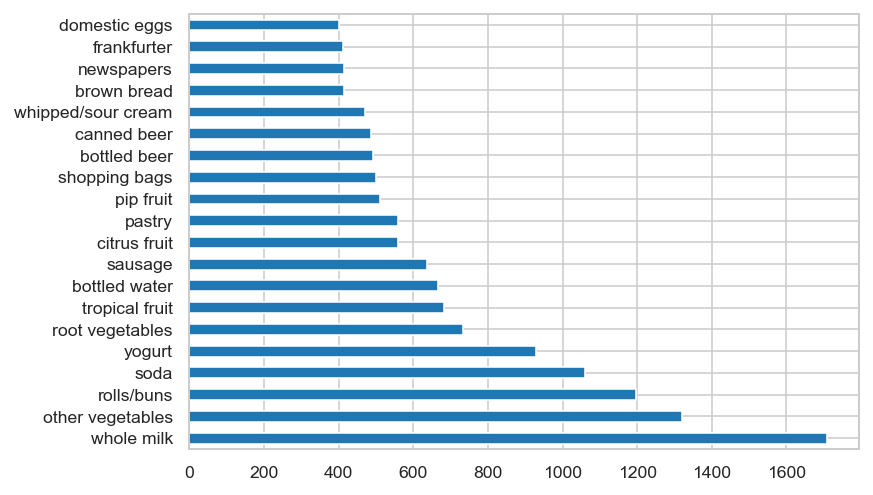

In [33]:
train_df['itemDescription'].value_counts()[:20].plot(kind='barh')

In [41]:
TOP_N_FOR_FREQUENT_ITEMS = 20

In [42]:
PLOT_COLOR = "#3e9a4c"
PLOT_CMAP = "Greens"

%config InlineBackend.figure_format = "retina"

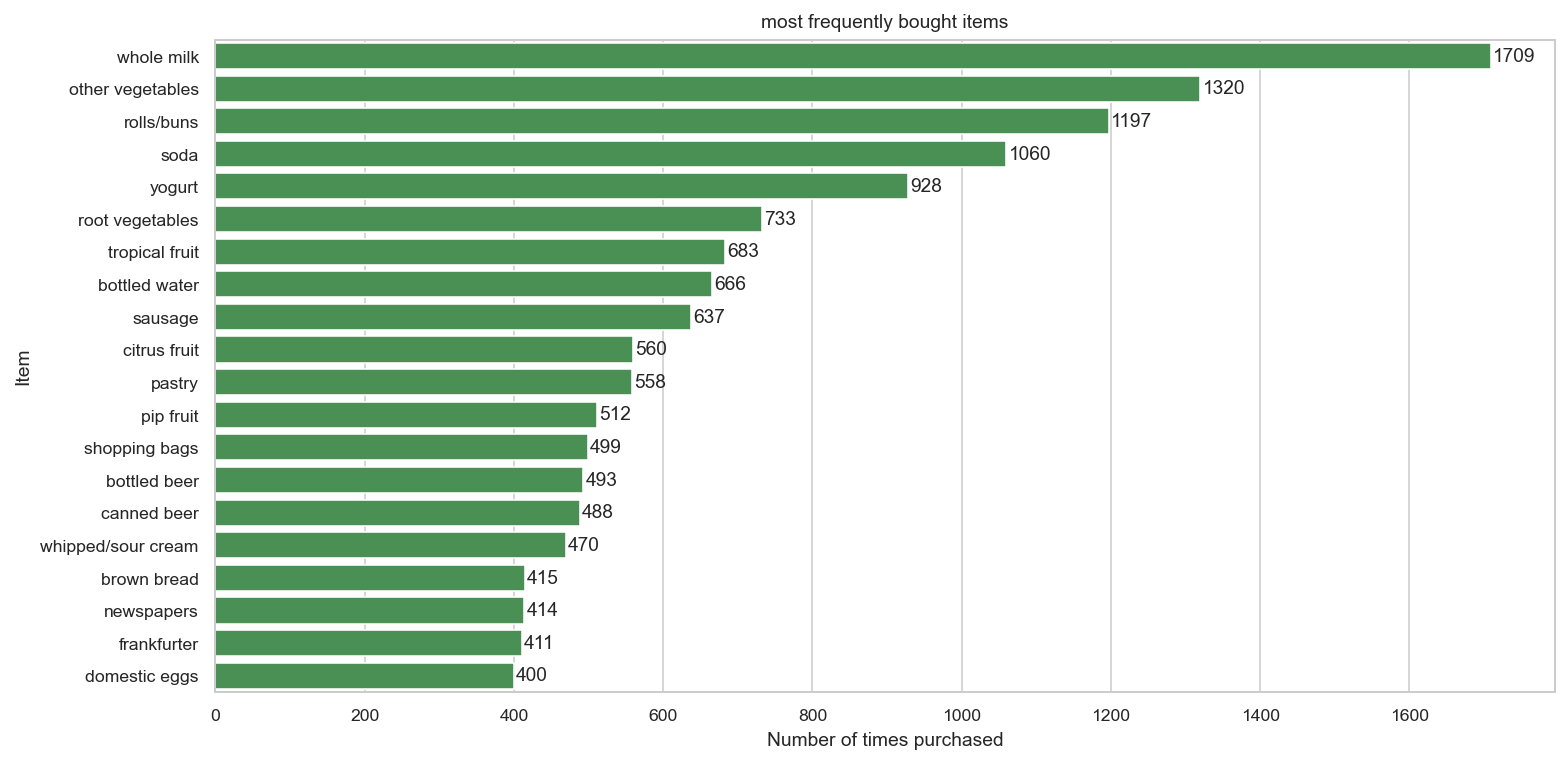

In [43]:
top_item_counts = train_df["itemDescription"].value_counts()[:20].reset_index()
top_item_counts.columns = ["itemDescription", "count"]

# plot counts
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.barplot(data=top_item_counts, y="itemDescription", x="count", color=PLOT_COLOR, ax=ax)
ax.bar_label(ax.containers[0], padding=1)
ax.set_xlabel("Number of times purchased")
ax.set_ylabel("Item")
ax.set_title( "most frequently bought items")


plt.show()

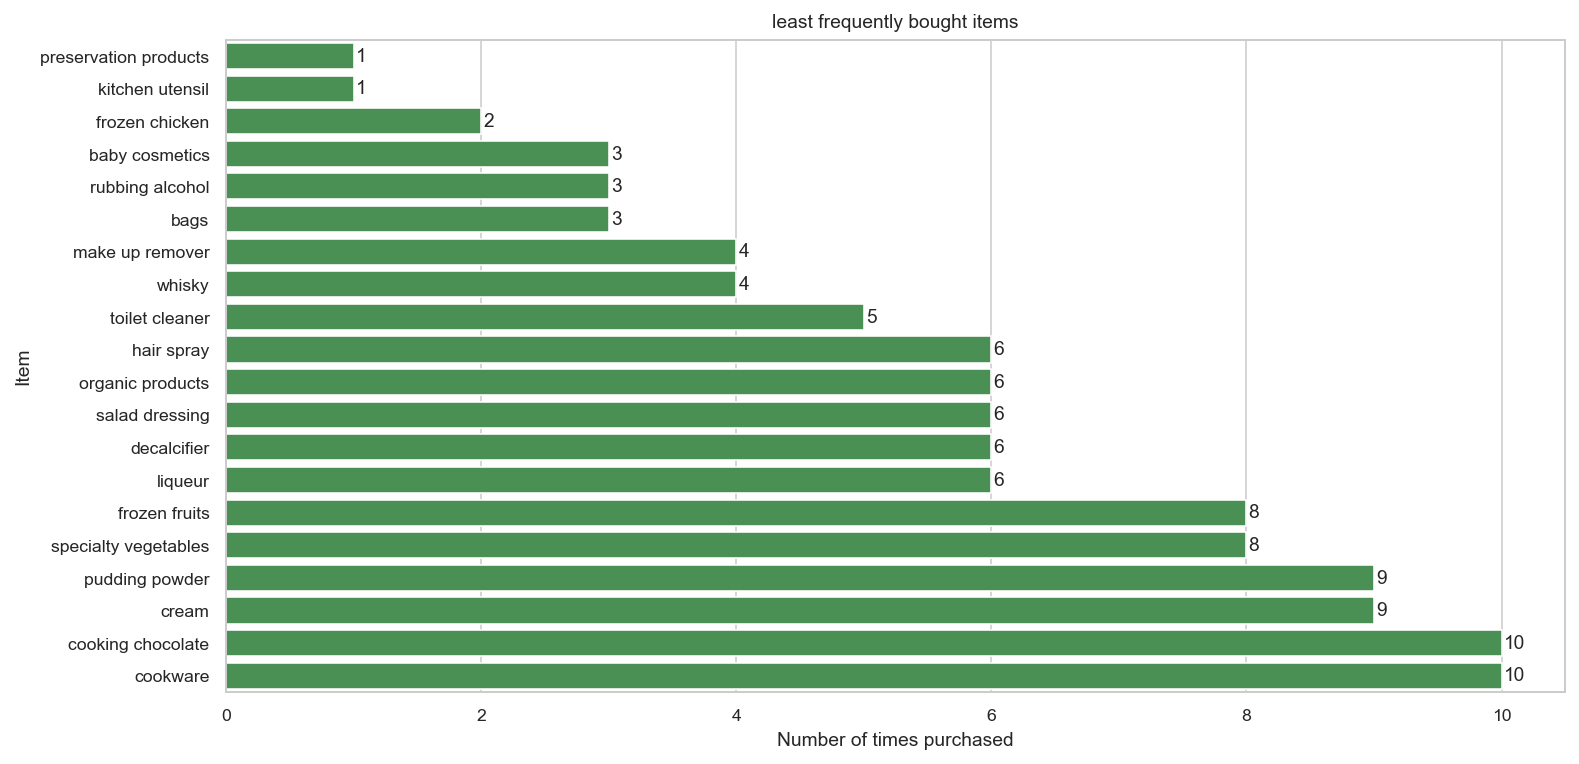

In [46]:
# get top N least frequently bought items
bottom_item_counts = train_df["itemDescription"].value_counts()[-TOP_N_FOR_FREQUENT_ITEMS:][::-1].reset_index()
bottom_item_counts.columns = ["itemDescription", "count"]

# plot counts
fig, ax = plt.subplots(figsize=(12, 6))

ax = sns.barplot(data=bottom_item_counts, y="itemDescription", x="count", color=PLOT_COLOR, ax=ax)
ax.bar_label(ax.containers[0], padding=1)
ax.set_xlabel("Number of times purchased")
ax.set_ylabel("Item")
ax.set_title("least frequently bought items")


plt.show()

In [47]:
train_df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week,OrderId,DoW_num,DoW
9895,2351,2014-01-01,shopping bags,2014,1,1,2,2351_2014-01-01,3,Wednesday
10966,1440,2014-01-01,yogurt,2014,1,1,2,1440_2014-01-01,3,Wednesday
276,1659,2014-01-01,frozen vegetables,2014,1,1,2,1659_2014-01-01,3,Wednesday
18723,3956,2014-01-01,chocolate,2014,1,1,2,3956_2014-01-01,3,Wednesday
21809,2237,2014-01-01,bottled water,2014,1,1,2,2237_2014-01-01,3,Wednesday


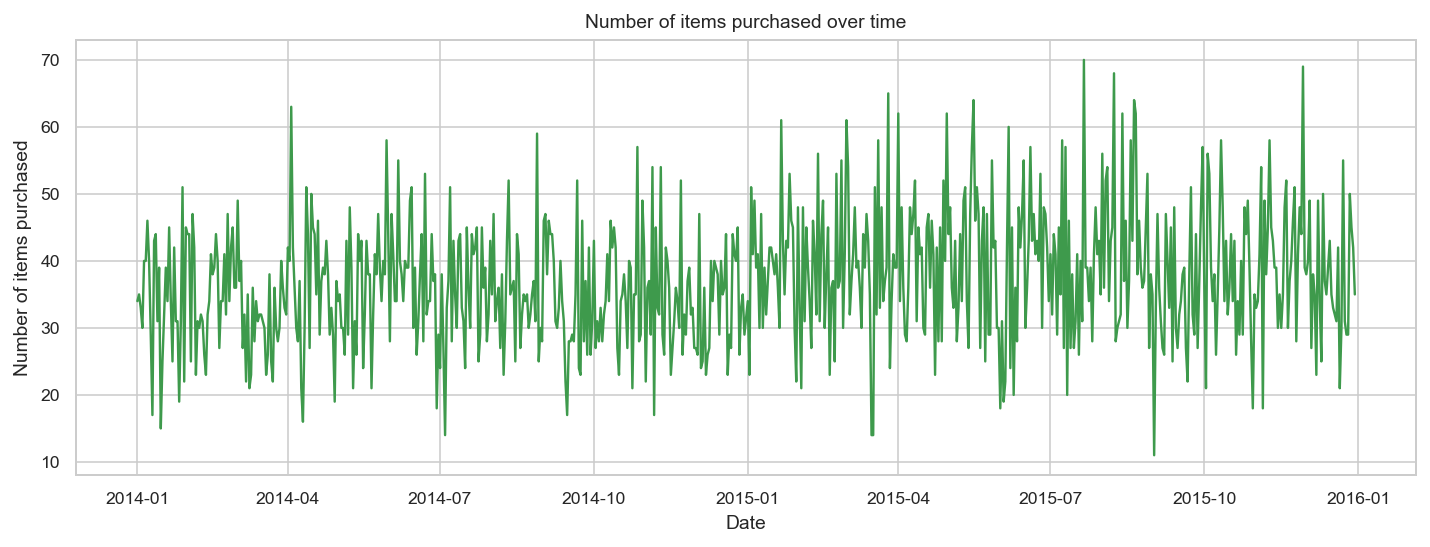

In [53]:
num_purchased_items_over_time_data = train_df.groupby("Date")["itemDescription"].size().reset_index()
num_purchased_items_over_time_data.columns = ["Date", "NumItemsBought"]

# plot counts over time
fig, ax = plt.subplots(figsize=(12, 4))

ax = sns.lineplot(x="Date", y="NumItemsBought", data=num_purchased_items_over_time_data, color=PLOT_COLOR, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Number of items purchased")
ax.set_title("Number of items purchased over time")


plt.show()

In [56]:
num_purchased_items_over_time_data.shape

(728, 2)

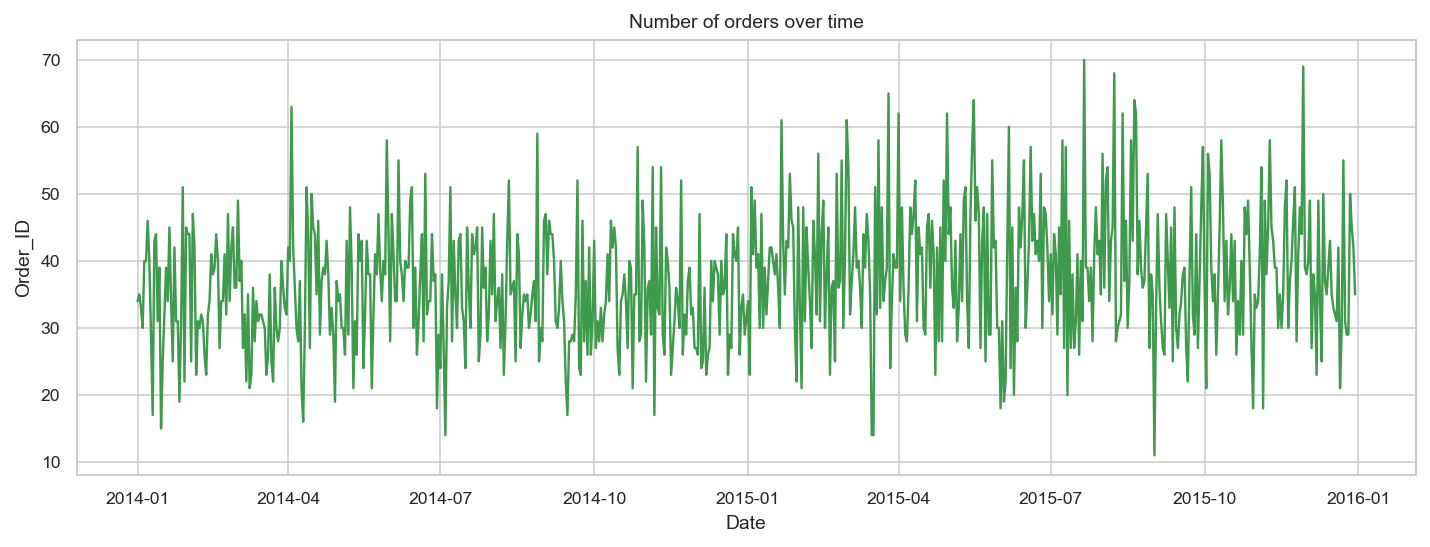

In [57]:
num_order_over_time = train_df.groupby("Date")["OrderId"].size().reset_index()
num_order_over_time_columns = ["Date", "OrderId"]
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.lineplot(x = "Date",y ="OrderId",data = num_order_over_time, color=PLOT_COLOR, ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Order_ID")
ax.set_title("Number of orders over time")
plt.show()

The number of orders appear to increase over time

## calculating average basket size

In [58]:
train_df.head()

,Member_number,Date,itemDescription,year,month,day,day_of_week,OrderId,DoW_num,DoW
9895,2351,2014-01-01,shopping bags,2014,1,1,2,2351_2014-01-01,3,Wednesday
10966,1440,2014-01-01,yogurt,2014,1,1,2,1440_2014-01-01,3,Wednesday
276,1659,2014-01-01,frozen vegetables,2014,1,1,2,1659_2014-01-01,3,Wednesday
18723,3956,2014-01-01,chocolate,2014,1,1,2,3956_2014-01-01,3,Wednesday
21809,2237,2014-01-01,bottled water,2014,1,1,2,2237_2014-01-01,3,Wednesday


In [70]:
duplicates = train_df[train_df.duplicated(subset=['Member_number'], keep=False)].value_counts()
duplicates.head()

Member_number  Date        itemDescription  year  month  day  day_of_week  OrderId          DoW_num  DoW      
4676           2015-01-15  sausage          2015  1      15   3            4676_2015-01-15  4        Thursday     3
4981           2015-01-10  margarine        2015  10     1    3            4981_2015-01-10  6        Saturday     3
4701           2015-04-30  soda             2015  4      30   3            4701_2015-04-30  4        Thursday     3
3679           2015-12-23  domestic eggs    2015  12     23   2            3679_2015-12-23  3        Wednesday    3
2430           2014-01-28  pastry           2014  1      28   1            2430_2014-01-28  2        Tuesday      3
dtype: int64

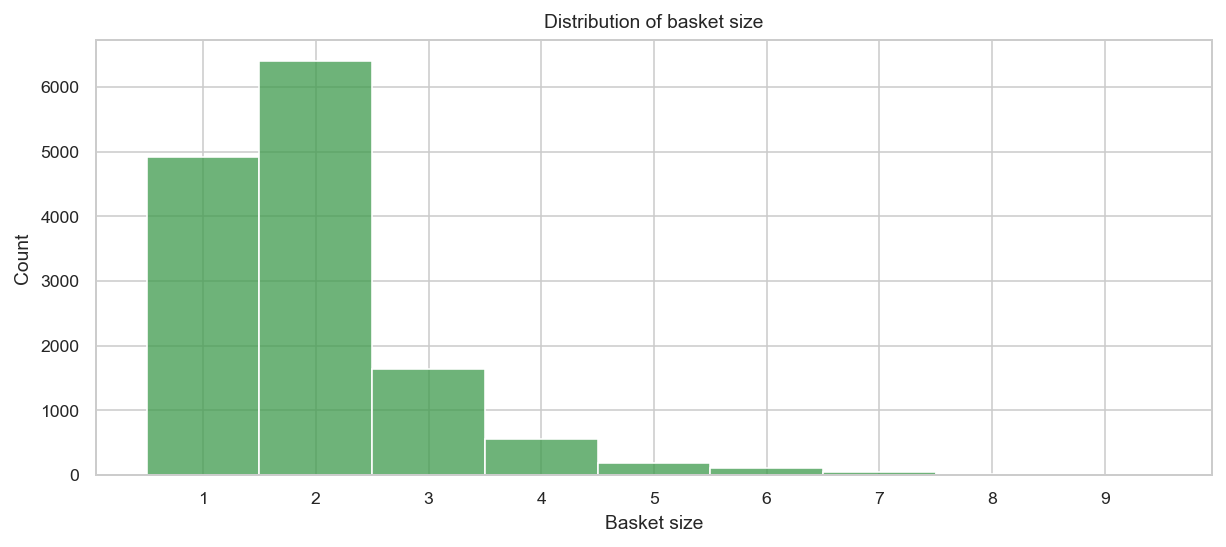

In [71]:
# get basket sizes
basket_sizes_over_time_data = train_df.groupby(["Date", "OrderId"]).size().reset_index()
basket_sizes_over_time_data.columns = ["Date", "OrderId", "BasketSize"]

# plot distribution of basket sizes
fig, ax = plt.subplots(figsize=(10, 4))

ax = sns.histplot(x="BasketSize", data=basket_sizes_over_time_data, discrete=True, color=PLOT_COLOR, ax=ax)
ax.set_xlabel("Basket size")
ax.set_ylabel("Count")
ax.set_xticks(range(1, basket_sizes_over_time_data["BasketSize"].max()+1))
ax.set_title("Distribution of basket size")


plt.show()

In [61]:
basket_sizes_over_time_data

,Date,OrderId,BasketSize
0,2014-01-01,1249_2014-01-01,2
1,2014-01-01,1381_2014-01-01,1
2,2014-01-01,1440_2014-01-01,1
3,2014-01-01,1659_2014-01-01,2
4,2014-01-01,1789_2014-01-01,2
...,...,...,...
13896,2015-12-30,3579_2015-12-30,3
13897,2015-12-30,3738_2015-12-30,2
13898,2015-12-30,3971_2015-12-30,1
13899,2015-12-30,4058_2015-12-30,1


Calculating avergae basket size over time

In [72]:
avg_basket_size_over_time = basket_sizes_over_time_data.groupby("Date")["BasketSize"].mean().reset_index()
avg_basket_size_over_time.columns = ["Date", "MeanBasketSize"]

In [78]:
avg_basket_size_over_time.columns

Index(['Date', 'MeanBasketSize'], dtype='object')

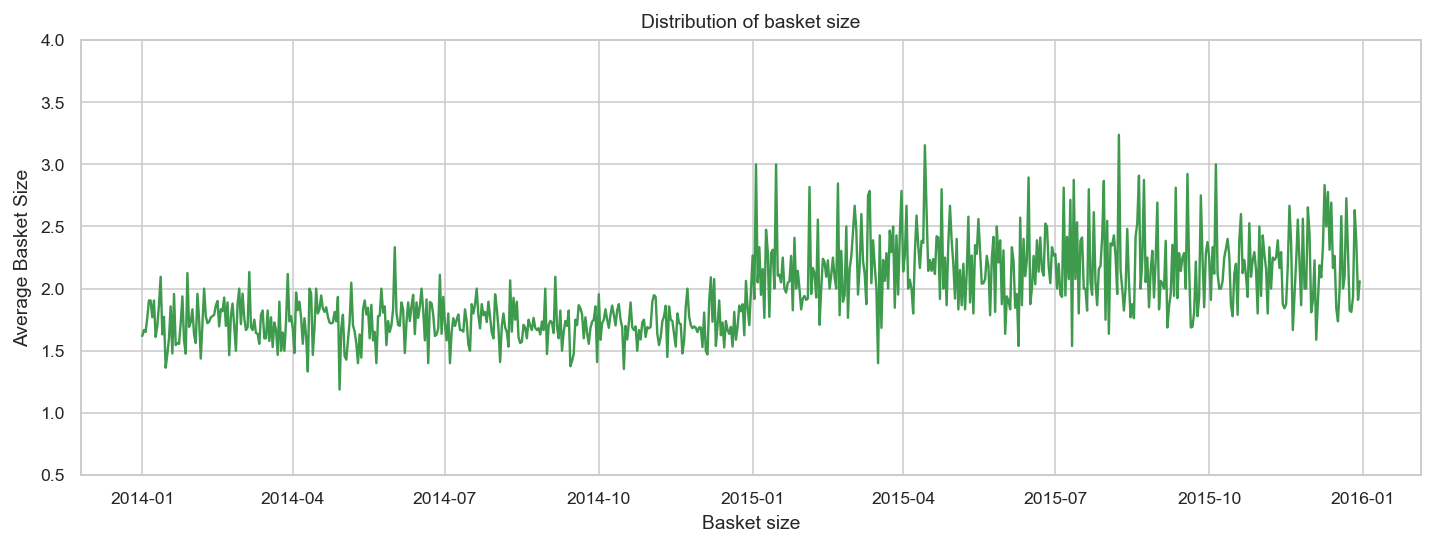

In [82]:
fig, ax = plt.subplots(figsize=(12, 4))
ax = sns.lineplot(x = "Date",y ="MeanBasketSize",data = avg_basket_size_over_time, color=PLOT_COLOR, ax=ax)
ax.set_xlabel("Basket size")
ax.set_ylabel("Average Basket Size")
ax.set_yticks(np.arange(start=0.5, stop=4.5, step=0.5))
ax.set_title("Distribution of basket size")
plt.show()


In [84]:
train_df.tail()

,Member_number,Date,itemDescription,year,month,day,day_of_week,OrderId,DoW_num,DoW
19189,1269,2015-09-12,other vegetables,2015,12,9,2,1269_2015-09-12,6,Saturday
26391,1077,2015-09-12,soda,2015,12,9,2,1077_2015-09-12,6,Saturday
1610,1269,2015-09-12,liquor,2015,12,9,2,1269_2015-09-12,6,Saturday
25568,3653,2015-09-12,rolls/buns,2015,12,9,2,3653_2015-09-12,6,Saturday
10855,4286,2015-09-12,photo/film,2015,12,9,2,4286_2015-09-12,6,Saturday


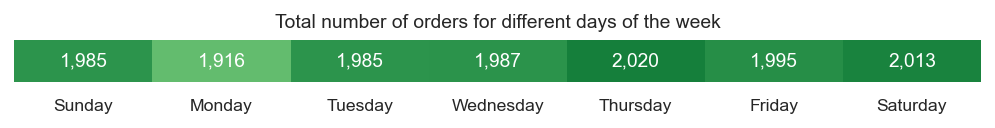

In [87]:
dow_order_counts = train_df.groupby(["DoW", "DoW_num"])["OrderId"].nunique().reset_index()
dow_order_counts.columns = ["dow", "dow_num", "num_orders"]
dow_order_counts = dow_order_counts.sort_values("dow_num")

# plot counts
fig, ax = plt.subplots(figsize=(7, 1))

ax = sns.heatmap(dow_order_counts["num_orders"].values.reshape(1, -1), annot=True, fmt=",", vmin=1700, vmax=2100, cmap=PLOT_CMAP, cbar=False, ax=ax)
ax.set_ylabel("Total number of orders")
ax.get_yaxis().set_visible(False)
ax.set_xticklabels(dow_order_counts["dow"].values)
ax.set_title("Total number of orders for different days of the week")

plt.tight_layout()

plt.show()

In [88]:
def generate_transactions_from_purchase_data(dataframe):
    """
    Prepare dataset as lists of transactions for frequent itemset mining.
    Each transaction is a list of items.
    """
    transactions = dataframe.groupby("OrderId")["itemDescription"].apply(list).tolist()
    return transactions

## Pattern finding


This is a Python function that takes a Pandas DataFrame as input and generates transactions from purchase data. The input DataFrame  have columns "OrderId" and "itemDescription", where "OrderId" represents the unique identifier of a purchase order and "itemDescription" represents the description of an item in that purchase order.

The function uses the Pandas groupby method to group the DataFrame by "OrderId". Then, it applies the "list" function to the "itemDescription" column of each group, which converts the column into a list. Finally, it converts the resulting Pandas Series of lists into a Python list of lists, where each inner list represents a transaction and contains the item descriptions for a particular order.

## This function is typically used for frequent itemset mining, which involves identifying sets of items that are frequently purchased together. By converting the purchase data into a list of transactions, it becomes easier to apply frequent itemset mining algorithms to the data.

In [90]:
transactions = generate_transactions_from_purchase_data(train_df)
transactions[:5]

[['pastry'],
 ['sausage', 'yogurt'],
 ['soda', 'pickled vegetables'],
 ['misc. beverages', 'canned beer'],
 ['sausage']]

Identify frequent itemsets

In [91]:
MIN_SUPPORT = 0.001

In [92]:
def generate_frequent_itemsets(transactions, min_support):
    """
    Generate frequent itemsets using a pattern mining algorithm.
    Return a dataframe containing the frequent itemsets and their support values.
    """
    # one-hot encode transactions
    encoder = TransactionEncoder()
    transactions_binary = encoder.fit_transform(transactions)
    transactions_one_hot = pd.DataFrame(transactions_binary, columns=encoder.columns_)
    # generate frequent itemsets and sort them in descending order of support
    frequent_itemsets = apriori(transactions_one_hot, min_support=min_support, use_colnames=True)
    frequent_itemsets = frequent_itemsets.sort_values("support", ascending=False)
    return frequent_itemsets

In [93]:
# view some frequent itemsets
frequent_itemsets = generate_frequent_itemsets(transactions, min_support=MIN_SUPPORT)
frequent_itemsets.head(10)

,support,itemsets
135,0.118049,(whole milk)
83,0.092799,(other vegetables)
100,0.083519,(rolls/buns)
113,0.074095,(soda)
136,0.064312,(yogurt)
101,0.051579,(root vegetables)
127,0.048414,(tropical fruit)
6,0.047119,(bottled water)
106,0.045249,(sausage)
86,0.039781,(pastry)
